# **Dreamweaver AI**
The goal of this project is to create the use of LLM for coherent story generation.

The plan is to use a base model to tune it to the use case. However, we did not have enough time and resources for training, therefore, we did just simple analysis on our rugged approach.

## Setup

Nothing fancy here, just your typical imports, and prerequisites.

In [ ]:
!pip install OpenAI tiktoken bert_score
!python -m spacy download en_core_web_md

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 51.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import os
import logging
from typing import List, Dict, Optional #Conradium
import tiktoken
from openai import OpenAI
import numpy as np
import spacy
import nltk
nltk.download('punkt_tab')
from nltk.translate.bleu_score import sentence_bleu
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from google.colab import userdata
import google.generativeai as genai
from bert_score import score
import time

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

## Classes
Collection of classes, for story generation and evaluation

### Story Generator
Here I use OpenAI API for the model mistral 7b instruct.
Instead of hosting a model from hugging face straight in colab, I used a readily available base model.

Their API is free to use.

In [ ]:
logger = logging.getLogger(__name__)

class StoryGenerator:
    def __init__(
        self,
        model: str = "mistralai/mistral-7b-instruct:free",
        provider: str = "openrouter",
        max_tokens: int = 4000,
        iterations: int = 1,
        temperature: float = 0.7,
        top_p: float = 0.9
    ):
        self.model = model
        self.provider = provider
        self.max_tokens = max_tokens
        self.iterations = iterations
        self.temperature = temperature
        self.top_p = top_p
        self.tokenizer = tiktoken.get_encoding("cl100k_base")
        self.story_memory: List[Dict] = []

        # Initialize client based on provider
        if provider == "openrouter":
            self.client = OpenAI(
                base_url='https://openrouter.ai/api/v1',
                api_key=userdata.get('openSecret')
            )
        elif provider == "google":
            genai.configure(api_key=userdata.get('googleSecret'))
            self.client = genai

    def _generate_completion(self, prompt: str, system_message: Optional[str] = None) -> str:
        try:
            if self.provider == "openrouter":
                messages = []

                if system_message:
                    messages.append({
                        "role": "system",
                        "content": system_message
                    })

                messages.append({
                    "role": "user",
                    "content": prompt
                })

                completion = self.client.chat.completions.create(
                    model=self.model,
                    messages=messages,
                    max_tokens=self.max_tokens,
                    temperature=self.temperature,
                    top_p=self.top_p
                )

                generated_text = completion.choices[0].message.content

            elif self.provider == "google":
                model = self.client.GenerativeModel('gemini-1.5-flash')
                # Combine system and user message for Google's API
                # LOL idk how to use system message on Gemini
                full_prompt = f"{system_message or ''}\n\n{prompt}"

                completion = model.generate_content(
                    full_prompt,
                    generation_config=genai.types.GenerationConfig(
                        max_output_tokens=self.max_tokens,
                        temperature=self.temperature,
                        top_p=self.top_p
                    )
                )

                generated_text = completion.text

            self.story_memory.append({
                "prompt": prompt,
                "response": generated_text
            })

            return generated_text

        except Exception as e:
            logger.error(f"Error generating completion: {e}")
            return ""

    def generate_story(self, initial_prompt: str, system_prompt: Optional[str] = None) -> str:
        if not system_prompt:
            system_prompt = (
                "You are a consistent storyteller. "
                "Maintain narrative flow, character development, "
                "and thematic coherence throughout the story."
            )

        full_text = self._generate_completion(
            initial_prompt,
            system_message=system_prompt
        )

        # Iterative story expansion
        for _ in range(self.iterations - 1):
            # context management: Use last 2000 tokens
            tokens = self.tokenizer.encode(full_text)
            context_tokens = tokens[-2000:]
            context = self.tokenizer.decode(context_tokens)

            continuation_prompt = (
                f"Continue the narrative, maintaining tone and style. "
                f"Previous Context:\n{context}\n\n"
                "Seamlessly extend the story, ensuring narrative coherence."
            )

            continuation = self._generate_completion(
                continuation_prompt,
                system_message=system_prompt
            )

            full_text += "\n\n" + continuation

        return full_text

    def analyze_story_structure(self, story: str) -> Dict:
        analysis_prompt = (
            f"Analyze the narrative structure of the following story:\n\n{story}\n\n"
            "Provide insights on: plot progression, character arcs, "
            "themes, and potential narrative turning points."
        )

        return {
            "raw_analysis": self._generate_completion(analysis_prompt)
        } #Conradium

I put in an unused function, analyze story structure and progression. This is for a deeper understanding how deep does the AI model understand the story.

Sometimes, what we see in the analysis is different than the generated text. We often see greater depth in the analysis than the generated text.

The reason behind might be do to the lack of reasoning when generation.

### Story Coherence Evaluator

Honestly, half of these concepts understanding are found on the internet.
It consists of natural language toolkit (nltk), BLEU and spaCy.
Basically what it does are:

NLTK:
1. Tokenization: Break down words or sentences
2. Stemming and lemmatization: Reduce words to their base root form
3. Text classification

Bleu (Bilingual Evaluation Understudy)'s role:
1. N-gram matching: Considers matches of different lengths, 1,2,3 grams etc to capture similarities level.

SpaCy:
1. Tokenization
2. Part-of-speech tagging: Identifying grammatical category
3. Named entity recognition: Identifying and classifying named entities in the text like organizations and people
4. Dependency parsing: Analyuze grammatical structure of a sentence.
5. Word embeddings: Representing words as vectors in a high-dimensional space, which helps in capturing semantic meaning.

In [ ]:
class StoryCoherenceEvaluator:
    def __init__(self):
        try:
            self.nlp = spacy.load('en_core_web_md')
            nltk.download('punkt')
        except Exception as e:
            print(f"Error loading NLP models: {e}")
            raise

    def semantic_coherence(self, text):
        doc = self.nlp(text)
        doc_vector = np.mean([token.vector for token in doc if token.has_vector], axis=0)

        sentences = [sent.text for sent in doc.sents]
        sentence_vectors = [self.nlp(sent).vector for sent in sentences]

        similarities = []
        for i in range(1, len(sentence_vectors)):
            similarity = cosine_similarity(
                sentence_vectors[i-1].reshape(1, -1),
                sentence_vectors[i].reshape(1, -1)
            )[0][0]
            similarities.append(similarity)

        return {
            'avg_sentence_similarity': np.mean(similarities) if similarities else 0,
            'semantic_coherence_score': np.mean(similarities) if similarities else 0
        }

    def lexical_coherence(self, text):
        sentences = nltk.sent_tokenize(text)

        # TF-IDF vectorization
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform(sentences)

        # Compute cosine similarities between consecutive sentences #THANK YOU CLAUDE SONNET
        similarities = []
        for i in range(1, len(sentences)):
            similarity = cosine_similarity(
                tfidf_matrix[i-1],
                tfidf_matrix[i]
            )[0][0]
            similarities.append(similarity)

        return {
            'lexical_similarity': np.mean(similarities) if similarities else 0,
            'lexical_coherence_score': np.mean(similarities) if similarities else 0
        }

    def narrative_flow_evaluation(self, text):
        sentences = nltk.sent_tokenize(text)

        # finds candidates for similarity/pattern in the output
        bleu_scores = []
        for i in range(1, len(sentences)):
            reference = [sentences[i-1].split()]
            candidate = sentences[i].split()
            bleu_score = sentence_bleu(reference, candidate)
            bleu_scores.append(bleu_score)

        return {
            'narrative_flow_score': np.mean(bleu_scores) if bleu_scores else 0,
            'narrative_progression_variance': np.std(bleu_scores) if bleu_scores else 0
        }

    def comprehensive_coherence_analysis(self, text):
        semantic_analysis = self.semantic_coherence(text)
        lexical_analysis = self.lexical_coherence(text)
        narrative_analysis = self.narrative_flow_evaluation(text)

        # scores combined with weight (reason: adjustable preference)
        coherence_score = (
            0.4 * semantic_analysis['semantic_coherence_score'] +
            0.3 * lexical_analysis['lexical_coherence_score'] +
            0.3 * narrative_analysis['narrative_flow_score']
        )

        return {
            'overall_coherence_score': coherence_score,
            'semantic_coherence': semantic_analysis,
            'lexical_coherence': lexical_analysis,
            'narrative_flow': narrative_analysis
        }

I also weighed the coherence score in this way

semantic:lexical:narrative

4:3:3

## BERT Scorer
Bert bert or brrt brrt, whatever it is.

In [ ]:
def evaluate_story_coherence(story, initial_prompt):
  references = [initial_prompt]
  candidates = [story]

  P, R, F1 = score(candidates, references, lang='en', verbose=True)

  return P, R, F1, print(f"Precision: {P.mean():.4f}, Recall: {R.mean():.4f}, F1: {F1.mean():.4f}")

## Usage

### Story

In [ ]:
mistral_generator = StoryGenerator(
    model="mistralai/mistral-7b-instruct:free",
    provider="openrouter"
)

# Google Gemini 1.5 Flash
gemini_generator = StoryGenerator(
    model="gemini-1.5-flash",
    provider="google"
)

initial_prompt = [
    """In a world where time flows differently in certain geographical regions.
    Instruction: Tell the story of a young cartographer who inherits a device capable of synchronizing time across these disparate zones.""",
    """A lone hacker discovers a conspiracy to enslave humanity in a neon-lit megacity.
    Instruction: Generate a dark, futuristic story about a rebellious hacker who uncovers a sinister plot to control the masses in a technologically advanced city.""",
    """A diverse crew of astronauts embarks on a perilous mission to a distant planet, only to find a long-lost civilization.
    Instruction: Create a thrilling space opera about a group of explorers who encounter ancient alien ruins and face unexpected challenges on a distant world.""",
    """A detective with supernatural abilities investigates a series of bizarre murders in a city teeming with hidden magic.
    Instruction: Develop a mysterious urban fantasy story about a detective who uses their supernatural powers to solve a series of gruesome
    murders in a city filled with mythical creatures and secret societies.""",
    """What if the Roman Empire had never fallen, and its influence extended into the 21st century?
    Instruction: Write a thought-provoking alternate history story about a world where the Roman Empire still exists in the modern era,
    exploring the political, social, and technological implications of this historical divergence."""]

generated_stories = {}

for prompt in initial_prompt:
    print(f"Generating story for prompt: {prompt}")
    s1 = mistral_generator.generate_story(prompt)
    s2 = gemini_generator.generate_story(prompt)

    generated_stories[prompt] = {
        'mistral_story': s1,
        'gemini_story': s2
    }
    time.sleep(5)

In [ ]:
for prompt, stories in generated_stories.items():
  print(stories["mistral_story"])

Title: The Chrono Compass: A Tale of Time and Tides

In the far-flung reaches of the cosmos, nestled between the swirling mists of the Eternity Sea, lies a world unlike any other. Known as Chronos, this realm is a tapestry of disparate time zones, each with its own rhythm, its own pace. It was here that our tale unfolds, in an age where the sands of time flowed like rivers, and the winds whispered the secrets of the ages.

Our protagonist, a young cartographer named Eira, was a native of the bustling city of Cronos, the heart of Chronos. Eira was a woman of curiosity and intellect, her heart brimming with a thirst for knowledge that could not be quenched by the maps and charts that filled her days. Her days were spent meticulously charting the ever-shifting currents of time, her nights dreaming of a world where the disparate zones could be united.

One fateful day, Eira received a mysterious package from an unknown sender. Inside was a device unlike any she had ever seen - a compass, b

### Coherence Evaluation

In [ ]:
# Initialize a dictionary to store all evaluation results
evaluation_results = {}

for prompt, stories in generated_stories.items():
    s1 = stories['mistral_story']
    s2 = stories['gemini_story']

    initial_prompt = prompt

    ce = StoryCoherenceEvaluator()
    print(f"\n--- Analyzing Stories for Prompt: {prompt} ---")

    prompt_results = {
        'prompt_snippet': prompt[:100] + '...',  # Store first 100 characters of prompt
        'mistral_analysis': {},
        'gemini_analysis': {},
        'bert_scores': {}
    }

    s1_analysis = ce.comprehensive_coherence_analysis(s1)

    prompt_results['mistral_analysis'] = {
        'overall_coherence_score': s1_analysis['overall_coherence_score'],
        'semantic_coherence': s1_analysis['semantic_coherence'],
        'lexical_coherence': s1_analysis['lexical_coherence'],
        'narrative_flow': s1_analysis['narrative_flow']
    }

    s2_analysis = ce.comprehensive_coherence_analysis(s2)

    prompt_results['gemini_analysis'] = {
        'overall_coherence_score': s2_analysis['overall_coherence_score'],
        'semantic_coherence': s2_analysis['semantic_coherence'],
        'lexical_coherence': s2_analysis['lexical_coherence'],
        'narrative_flow': s2_analysis['narrative_flow']
    }

    P1, R1, F11 = evaluate_story_coherence(s1, initial_prompt)[:3]
    P2, R2, F12 = evaluate_story_coherence(s2, initial_prompt)[:3]

    prompt_results['bert_scores'] = {
        'mistral': {
            'precision': P1.mean(),
            'recall': R1.mean(),
            'f1': F11.mean()
        },
        'gemini': {
            'precision': P2.mean(),
            'recall': R2.mean(),
            'f1': F12.mean()
        }
    }

    if F11.mean() > F12.mean():
        prompt_results['better_coherence'] = 'Mistral'
    elif F12.mean() > F11.mean():
        prompt_results['better_coherence'] = 'Gemini'
    else:
        prompt_results['better_coherence'] = 'Tie'
    evaluation_results[prompt] = prompt_results



/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



--- Analyzing Stories for Prompt: In a world where time flows differently in certain geographical regions. 
    Instruction: Tell the story of a young cartographer who inherits a device capable of synchronizing time across these disparate zones. ---


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.51 sentences/sec
Precision: 0.7896, Recall: 0.8578, F1: 0.8223


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.12 sentences/sec
Precision: 0.7881, Recall: 0.8558, F1: 0.8206


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



--- Analyzing Stories for Prompt: A lone hacker discovers a conspiracy to enslave humanity in a neon-lit megacity. 
    Instruction: Generate a dark, futuristic story about a rebellious hacker who uncovers a sinister plot to control the masses in a technologically advanced city. ---


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.79 sentences/sec
Precision: 0.8011, Recall: 0.8586, F1: 0.8289


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.59 sentences/sec
Precision: 0.7935, Recall: 0.8526, F1: 0.8220


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



--- Analyzing Stories for Prompt: A diverse crew of astronauts embarks on a perilous mission to a distant planet, only to find a long-lost civilization. 
    Instruction: Create a thrilling space opera about a group of explorers who encounter ancient alien ruins and face unexpected challenges on a distant world. ---


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 10.03 sentences/sec
Precision: 0.7994, Recall: 0.8614, F1: 0.8293


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.25 sentences/sec
Precision: 0.7828, Recall: 0.8408, F1: 0.8107


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



--- Analyzing Stories for Prompt: A detective with supernatural abilities investigates a series of bizarre murders in a city teeming with hidden magic. 
    Instruction: Develop a mysterious urban fantasy story about a detective who uses their supernatural powers to solve a series of gruesome 
    murders in a city filled with mythical creatures and secret societies. ---


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.94 sentences/sec
Precision: 0.7980, Recall: 0.8388, F1: 0.8179


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.76 sentences/sec
Precision: 0.7924, Recall: 0.8388, F1: 0.8150


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



--- Analyzing Stories for Prompt: What if the Roman Empire had never fallen, and its influence extended into the 21st century? 
    Instruction: Write a thought-provoking alternate history story about a world where the Roman Empire still exists in the modern era, 
    exploring the political, social, and technological implications of this historical divergence. ---


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.57 sentences/sec
Precision: 0.7959, Recall: 0.8408, F1: 0.8178


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.30 sentences/sec
Precision: 0.7848, Recall: 0.8221, F1: 0.8030


Coherence Comparison Summary

Mistral Model Performance:
--------------------
Overall Coherence Scores:
  Mean: 0.3621
  Median: 0.3654
  Std Dev: 0.0190
  Min: 0.3338
  Max: 0.3919

BERT F1 Scores:
  Mean: 0.8232
  Median: 0.8223
  Std Dev: 0.0051

Gemini Model Performance:
--------------------
Overall Coherence Scores:
  Mean: 0.3380
  Median: 0.3428
  Std Dev: 0.0097
  Min: 0.3212
  Max: 0.3492

BERT F1 Scores:
  Mean: 0.8143
  Median: 0.8150
  Std Dev: 0.0069

Statistical Tests Results:
--------------------
Overall Scores T-Test: t-statistic = 2.2638, p-value = 0.0534
BERT F1 Scores T-Test: t-statistic = 2.0901, p-value = 0.0700

Prompt Level Comparisons:
Prompt: In a world where time flows differently in certain...
  Mistral Overall: 0.3919
  Gemini Overall: 0.3337
  Mistral BERT F1: 0.8223
  Gemini BERT F1: 0.8206
  Better Model: Mistral
--------------------
Prompt: A lone hacker discovers a conspiracy to enslave hu...
  Mistral Overall: 0.3338
  Gemini Overall: 0.3212
  Mistral 

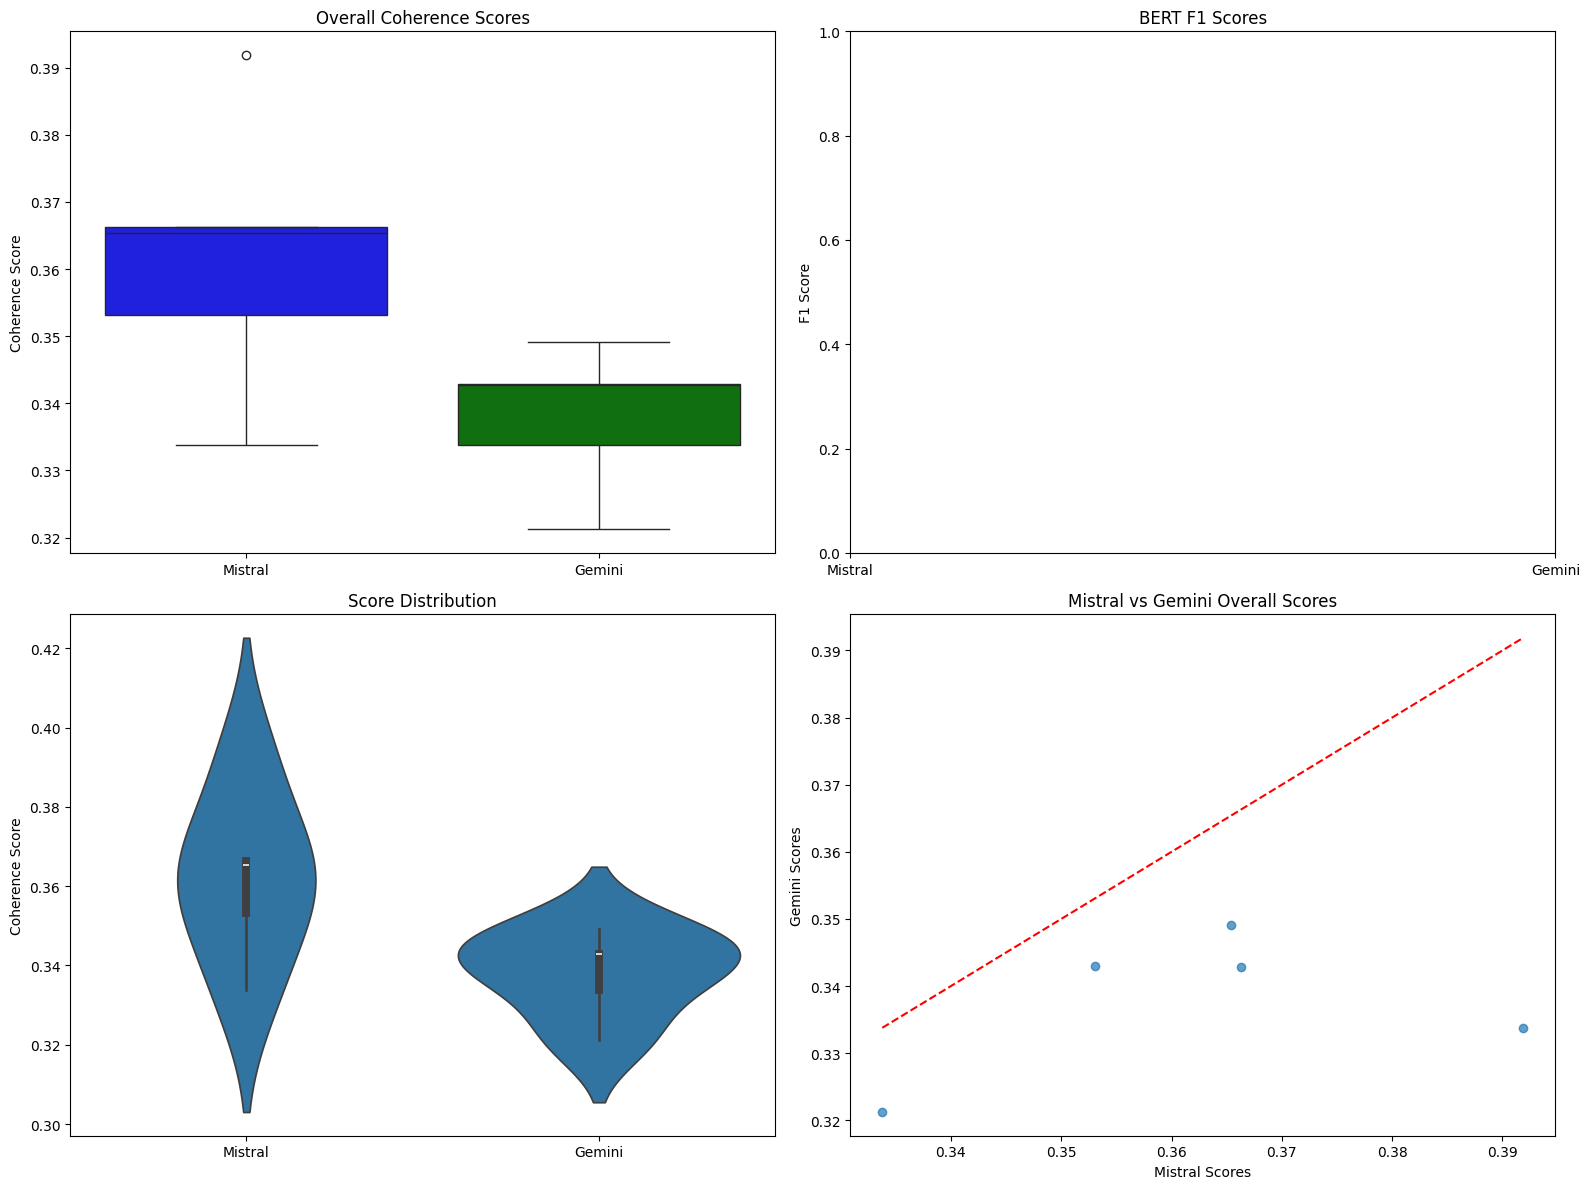

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def compare_story_coherence(evaluation_results):
    """
    Comprehensive coherence comparison

    Args:
        evaluation_results (dict): Comprehensive evaluation results

    Returns:
        dict: Detailed comparison summary
    """
    comparison_summary = {
        'model_performance': {
            'Mistral': {'overall_scores': [], 'bert_f1_scores': []},
            'Gemini': {'overall_scores': [], 'bert_f1_scores': []}
        },
        'statistical_insights': {},
        'prompt_level_comparisons': []
    }

    # Collect metrics for each prompt
    for prompt, results in evaluation_results.items():
        # Extract scores
        mistral_overall = results['mistral_analysis']['overall_coherence_score']
        gemini_overall = results['gemini_analysis']['overall_coherence_score']

        mistral_bert_f1 = results['bert_scores']['mistral']['f1']
        gemini_bert_f1 = results['bert_scores']['gemini']['f1']

        # Store scores
        comparison_summary['model_performance']['Mistral']['overall_scores'].append(mistral_overall)
        comparison_summary['model_performance']['Gemini']['overall_scores'].append(gemini_overall)

        comparison_summary['model_performance']['Mistral']['bert_f1_scores'].append(mistral_bert_f1)
        comparison_summary['model_performance']['Gemini']['bert_f1_scores'].append(gemini_bert_f1)

        # Prompt-level comparison
        comparison_summary['prompt_level_comparisons'].append({
            'prompt': prompt[:50] + '...',  # Truncated prompt
            'mistral_overall': mistral_overall,
            'gemini_overall': gemini_overall,
            'mistral_bert_f1': mistral_bert_f1,
            'gemini_bert_f1': gemini_bert_f1,
            'better_model': results['better_coherence']
        })

    # Statistical Analysis
    def compute_model_stats(scores):
        return {
            'mean': np.mean(scores),
            'median': np.median(scores),
            'std': np.std(scores),
            'min': np.min(scores),
            'max': np.max(scores)
        }

    # Compute statistics for both models
    comparison_summary['statistical_insights'] = {
        'Mistral': {
            'overall_scores': compute_model_stats(comparison_summary['model_performance']['Mistral']['overall_scores']),
            'bert_f1_scores': compute_model_stats(comparison_summary['model_performance']['Mistral']['bert_f1_scores'])
        },
        'Gemini': {
            'overall_scores': compute_model_stats(comparison_summary['model_performance']['Gemini']['overall_scores']),
            'bert_f1_scores': compute_model_stats(comparison_summary['model_performance']['Gemini']['bert_f1_scores'])
        }
    }

    # Statistical Tests
    mistral_overall = comparison_summary['model_performance']['Mistral']['overall_scores']
    gemini_overall = comparison_summary['model_performance']['Gemini']['overall_scores']

    mistral_f1 = comparison_summary['model_performance']['Mistral']['bert_f1_scores']
    gemini_f1 = comparison_summary['model_performance']['Gemini']['bert_f1_scores']

    comparison_summary['statistical_tests'] = {
        'overall_scores_ttest': stats.ttest_ind(mistral_overall, gemini_overall),
        'bert_f1_ttest': stats.ttest_ind(mistral_f1, gemini_f1)
    }

    return comparison_summary

def visualize_comparison(comparison_results):
    """
    Create comprehensive visualizations

    Args:
        comparison_results (dict): Comparison results
    """
    plt.figure(figsize=(16, 12))

    # Overall Scores Boxplot
    plt.subplot(2, 2, 1)
    mistral_overall = comparison_results['model_performance']['Mistral']['overall_scores']
    gemini_overall = comparison_results['model_performance']['Gemini']['overall_scores']

    sns.boxplot(data=[mistral_overall, gemini_overall],
                orient='v',
                palette=['blue', 'green'])
    plt.title('Overall Coherence Scores')
    plt.xticks([0, 1], ['Mistral', 'Gemini'])
    plt.ylabel('Coherence Score')

    # BERT F1 Scores Boxplot
    plt.subplot(2, 2, 2)
    mistral_f1 = comparison_results['model_performance']['Mistral']['bert_f1_scores']
    gemini_f1 = comparison_results['model_performance']['Gemini']['bert_f1_scores']

    sns.boxplot(data=[mistral_f1, gemini_f1],
                orient='v',
                palette=['blue', 'green'])
    plt.title('BERT F1 Scores')
    plt.xticks([0, 1], ['Mistral', 'Gemini'])
    plt.ylabel('F1 Score')

    # Violin Plots for Distribution
    plt.subplot(2, 2, 3)
    combined_overall = mistral_overall + gemini_overall
    labels = ['Mistral']*len(mistral_overall) + ['Gemini']*len(gemini_overall)

    sns.violinplot(x=labels, y=combined_overall)
    plt.title('Score Distribution')
    plt.ylabel('Coherence Score')

    # Scatter Plot of Scores
    plt.subplot(2, 2, 4)
    plt.scatter(mistral_overall, gemini_overall, alpha=0.7)
    plt.title('Mistral vs Gemini Overall Scores')
    plt.xlabel('Mistral Scores')
    plt.ylabel('Gemini Scores')
    plt.plot([min(mistral_overall), max(mistral_overall)],
             [min(mistral_overall), max(mistral_overall)],
             color='red', linestyle='--')

    plt.tight_layout()
    plt.savefig('model_comparison.png')
    # plt.close()

def print_comparison_summary(comparison_results):
    """
    Print a detailed textual summary of the comparison

    Args:
        comparison_results (dict): Comparison results
    """
    print("Coherence Comparison Summary")
    print("=" * 30)

    # Model Performance
    for model in ['Mistral', 'Gemini']:
        print(f"\n{model} Model Performance:")
        print("-" * 20)

        # Overall Scores
        overall_stats = comparison_results['statistical_insights'][model]['overall_scores']
        print("Overall Coherence Scores:")
        print(f"  Mean: {overall_stats['mean']:.4f}")
        print(f"  Median: {overall_stats['median']:.4f}")
        print(f"  Std Dev: {overall_stats['std']:.4f}")
        print(f"  Min: {overall_stats['min']:.4f}")
        print(f"  Max: {overall_stats['max']:.4f}")

        # BERT F1 Scores
        f1_stats = comparison_results['statistical_insights'][model]['bert_f1_scores']
        print("\nBERT F1 Scores:")
        print(f"  Mean: {f1_stats['mean']:.4f}")
        print(f"  Median: {f1_stats['median']:.4f}")
        print(f"  Std Dev: {f1_stats['std']:.4f}")

    # Statistical Tests
    overall_ttest = comparison_results['statistical_tests']['overall_scores_ttest']
    f1_ttest = comparison_results['statistical_tests']['bert_f1_ttest']

    print("\nStatistical Tests Results:")
    print("-" * 20)
    print(f"Overall Scores T-Test: t-statistic = {overall_ttest.statistic:.4f}, p-value = {overall_ttest.pvalue:.4f}")
    print(f"BERT F1 Scores T-Test: t-statistic = {f1_ttest.statistic:.4f}, p-value = {f1_ttest.pvalue:.4f}")

    print("\nPrompt Level Comparisons:")
    print("=" * 30)
    for comparison in comparison_results['prompt_level_comparisons']:
        print(f"Prompt: {comparison['prompt']}")
        print(f"  Mistral Overall: {comparison['mistral_overall']:.4f}")
        print(f"  Gemini Overall: {comparison['gemini_overall']:.4f}")
        print(f"  Mistral BERT F1: {comparison['mistral_bert_f1']:.4f}")
        print(f"  Gemini BERT F1: {comparison['gemini_bert_f1']:.4f}")
        print(f"  Better Model: {comparison['better_model']}")
        print("-" * 20)

comparison_results = compare_story_coherence(evaluation_results)  # This line is added
visualize_comparison(comparison_results)  # Pass comparison_results instead of evaluation_results
print_comparison_summary(comparison_results) # Pass comparison_results instead of evaluation_results